In [4]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary

from models.transLOB_v3 import TransLOB
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading Data

In [6]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

## Processing Data

In [7]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 128 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_20'
LABEL_ALPHA = 5e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

normalization = 'Zscore'

In [8]:
raw_df = pd.read_csv(DATA_PATH, index_col=0)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [9]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
midpoint_delta_features = ['midpoint_delta']

feature_cols = distance_features + notional_features

raw_df['system_time'] = pd.to_datetime(raw_df['system_time'])
raw_df = raw_df[meta_features + distance_features + notional_features + market_notional_features]
raw_df = generate_labels(raw_df, HORIZONS, alpha=LABEL_ALPHA)
raw_df = add_features(raw_df)
raw_df = normalize_features(raw_df, normalization)
raw_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,y_10,y_20,y_30,y_50,y_100,midpoint_delta
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.000190
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.000190
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.000190
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.000190
5,2021-04-07 11:32:47.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.000190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030723,2021-04-19 09:54:18.386544+00:00,56863.725,0.01,0.000000,0.000000,-1.249153,-1.248275,-1.248130,-1.247497,-1.247002,...,0.0,0.0,0.0,0.0,1,1,1,1,1,-0.000190
1030724,2021-04-19 09:54:19.386544+00:00,56863.725,0.01,0.000000,0.000000,-1.249153,-1.248275,-1.248134,-1.247610,-1.247071,...,0.0,0.0,0.0,0.0,1,1,1,1,1,-0.000190
1030725,2021-04-19 09:54:20.386544+00:00,56863.725,0.01,1506.866100,0.000000,-1.249153,-1.248275,-1.248134,-1.247678,-1.248661,...,0.0,0.0,0.0,0.0,1,1,1,1,1,-0.000190
1030726,2021-04-19 09:54:21.386544+00:00,56863.725,0.01,0.000000,0.000000,-1.249153,-1.248275,-1.248134,-1.247678,-1.249351,...,0.0,0.0,0.0,0.0,1,1,1,1,1,-0.000190


In [71]:
data_df = raw_df[:200100]
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,y_10,y_20,y_30,y_50,y_100,midpoint_delta
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.00019
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.00019
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.00019
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.00019
5,2021-04-07 11:32:47.122161+00:00,56035.995,0.01,0.000000,0.000000,-1.581542,-1.580662,-1.581072,-1.584825,-1.585163,...,0.0,0.0,0.0,0.0,1,2,2,2,2,-0.00019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200096,2021-04-09 19:08:18.172509+00:00,58425.705,0.01,18.411694,3175.859797,-0.621914,-0.624333,-0.623612,-0.623002,-0.622482,...,0.0,0.0,0.0,0.0,2,2,1,2,2,-0.00019
200097,2021-04-09 19:08:19.172509+00:00,58425.705,0.01,32.845181,0.000000,-0.621914,-0.624325,-0.623604,-0.623074,-0.623647,...,0.0,0.0,0.0,0.0,2,2,1,2,2,-0.00019
200098,2021-04-09 19:08:20.172509+00:00,58425.705,0.01,490.206898,3120.482750,-0.621914,-0.624272,-0.623548,-0.622946,-0.622378,...,0.0,0.0,0.0,0.0,2,2,1,2,2,-0.00019
200099,2021-04-09 19:08:21.172509+00:00,58425.705,0.01,0.000000,0.000000,-0.621914,-0.623943,-0.624877,-0.624251,-0.624390,...,0.0,0.0,0.0,0.0,2,2,1,1,2,-0.00019


## EDA

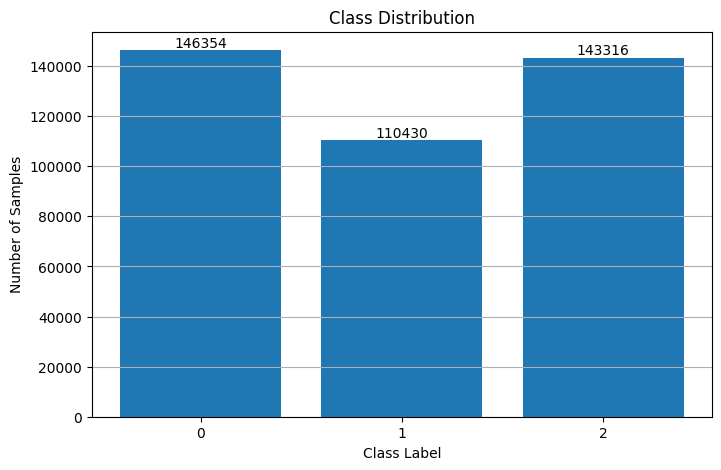

In [55]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

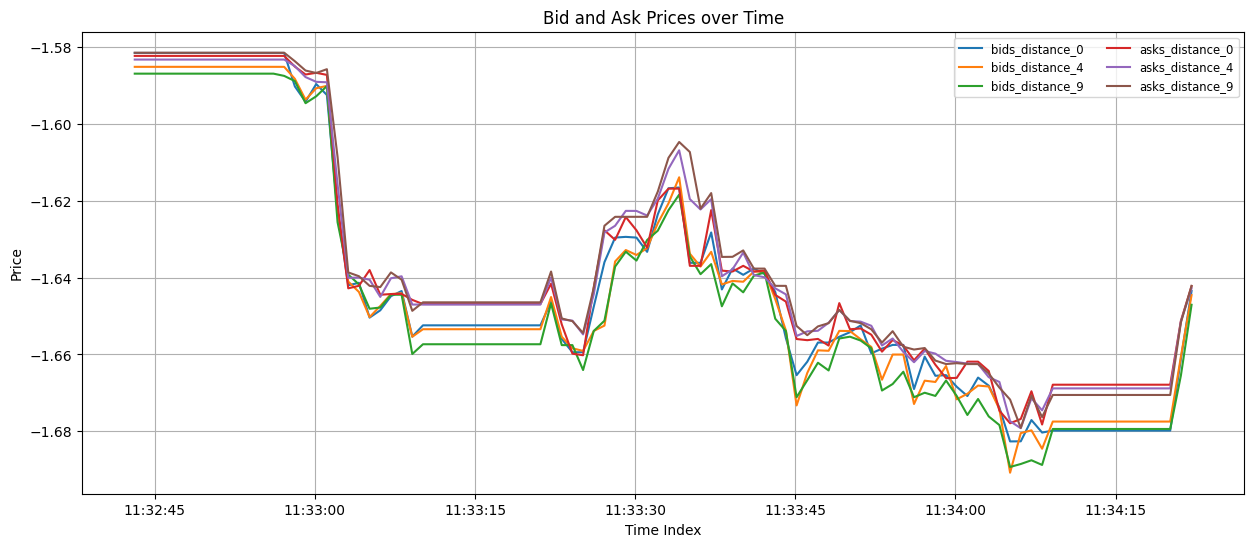

In [56]:
bid_price_cols = ['bids_distance_0','bids_distance_4','bids_distance_9']
ask_price_cols = ['asks_distance_0','asks_distance_4','asks_distance_9']

plot_range = 100

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

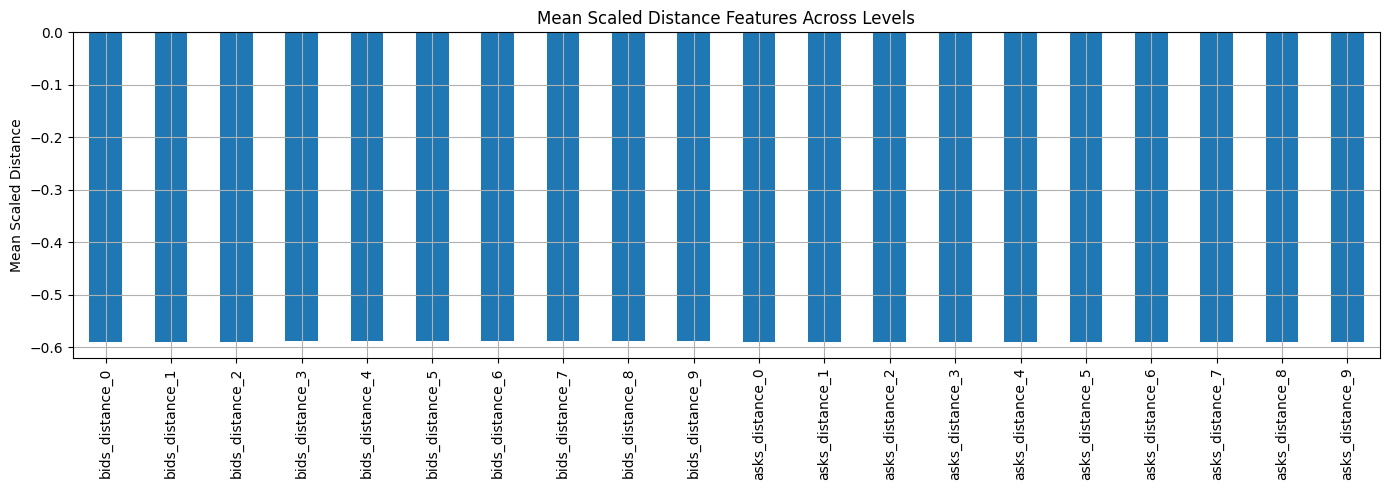

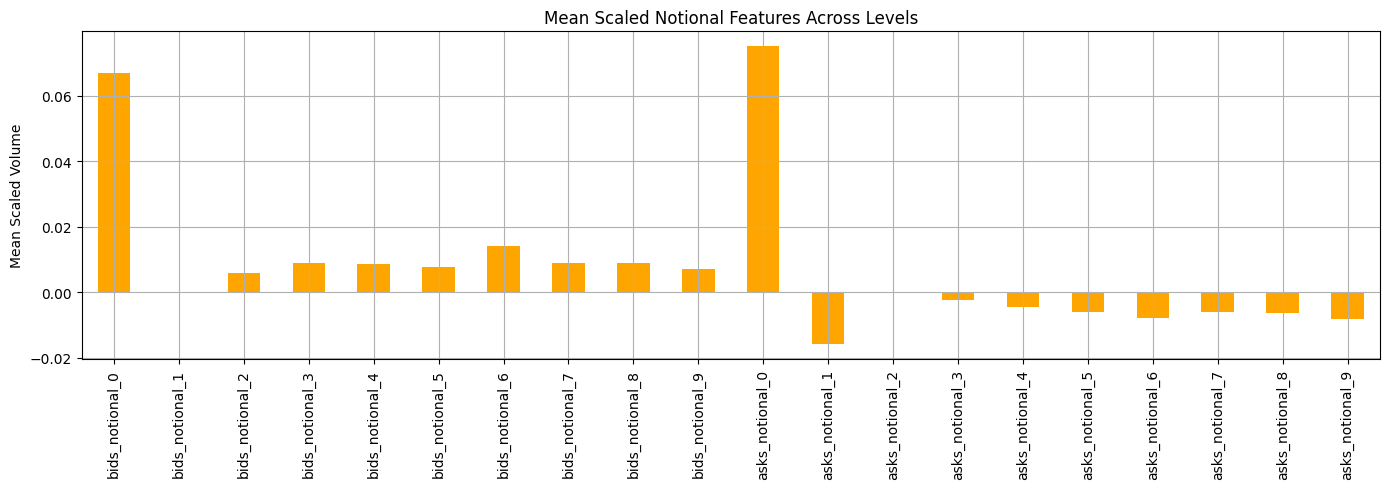

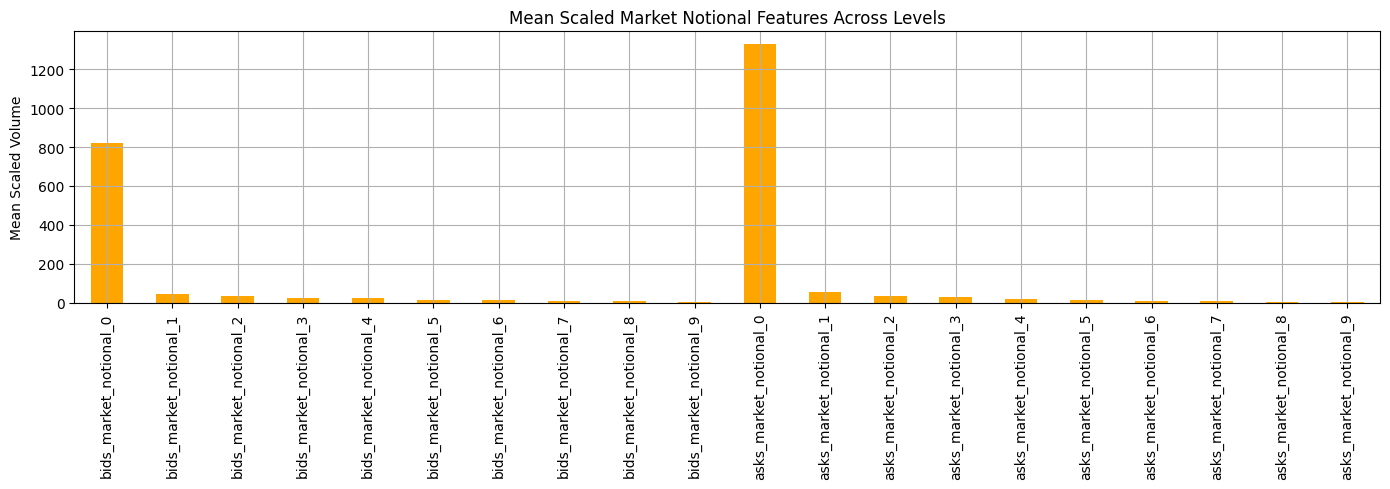

In [57]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[market_notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Market Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((200100, 40), (200100,))

In [73]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(200000, 100, 40)

In [74]:
hold = 0.1
X_train, X_val, y_train, y_val = train_test_split(
    X_windows[:int(len(X_windows)*(1-hold))], y_labels[:int(len(X_windows)*(1-hold))], 
    test_size=2/9, random_state=42, shuffle=True
)
X_val = np.concatenate([X_val, X_windows[-int(len(X_windows)*hold):]], axis=0)
y_val = np.concatenate([y_val, y_labels[-int(len(X_windows)*hold):]], axis=0)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")

Train shape: (140000, 100, 40), (140000,)
Validation shape: (60000, 100, 40), (60000,)


In [61]:
# distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
# notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

# combined = pd.DataFrame({
#     "distance": distances["distance_value"],
#     "notional": notionals["notional_value"]
# })

# plt.figure(figsize=(14, 6))
# plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
# plt.xlabel('Distance from Midprice')
# plt.ylabel('Notional Volume')
# plt.title('Price Distance vs Notional Volume')
# plt.grid(True)
# plt.show()

## TransLOB

In [75]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [76]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=31,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

summary(model, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor2D: 1-1             [1, 100, 640]             --
│    └─Sequential: 2-1                   [1, 32, 100, 20]          --
│    │    └─Conv2d: 3-1                  [1, 32, 100, 20]          96
│    │    └─LeakyReLU: 3-2               [1, 32, 100, 20]          --
│    │    └─BatchNorm2d: 3-3             [1, 32, 100, 20]          64
│    │    └─Conv2d: 3-4                  [1, 32, 100, 20]          3,104
│    │    └─LeakyReLU: 3-5               [1, 32, 100, 20]          --
│    │    └─BatchNorm2d: 3-6             [1, 32, 100, 20]          64
│    │    └─Conv2d: 3-7                  [1, 32, 100, 20]          3,104
│    │    └─LeakyReLU: 3-8               [1, 32, 100, 20]          --
│    │    └─BatchNorm2d: 3-9             [1, 32, 100, 20]          64
├─Linear: 1-2                            [1, 100, 63]              40,383
├─LOB

In [77]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 20
best_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")

Epoch 1/20: Train Loss 1.0283 | Train Acc 0.4665 | Val Loss 1.0211 | Val Acc 0.4720
✅ Saved best model at epoch 1 with Val Acc 0.4720
Epoch 2/20: Train Loss 0.9955 | Train Acc 0.4971 | Val Loss 0.9998 | Val Acc 0.4960
✅ Saved best model at epoch 2 with Val Acc 0.4960
Epoch 3/20: Train Loss 0.9488 | Train Acc 0.5386 | Val Loss 0.9677 | Val Acc 0.5334
✅ Saved best model at epoch 3 with Val Acc 0.5334
Epoch 4/20: Train Loss 0.8491 | Train Acc 0.6141 | Val Loss 0.9558 | Val Acc 0.5624
✅ Saved best model at epoch 4 with Val Acc 0.5624
Epoch 5/20: Train Loss 0.7444 | Train Acc 0.6818 | Val Loss 0.9425 | Val Acc 0.5945
✅ Saved best model at epoch 5 with Val Acc 0.5945
Epoch 6/20: Train Loss 0.6658 | Train Acc 0.7256 | Val Loss 0.9411 | Val Acc 0.6116
✅ Saved best model at epoch 6 with Val Acc 0.6116
Epoch 7/20: Train Loss 0.6082 | Train Acc 0.7544 | Val Loss 0.9563 | Val Acc 0.6256
✅ Saved best model at epoch 7 with Val Acc 0.6256
Epoch 8/20: Train Loss 0.5636 | Train Acc 0.7758 | Val Loss 0.

KeyboardInterrupt: 

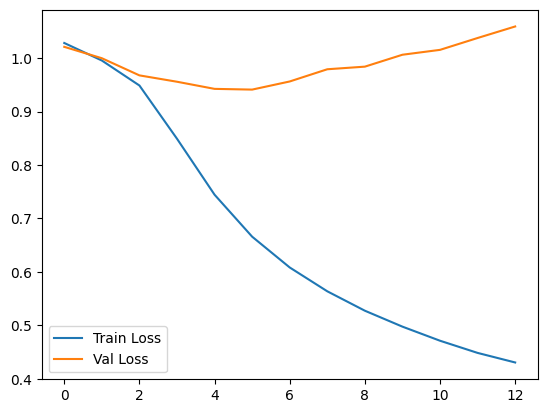

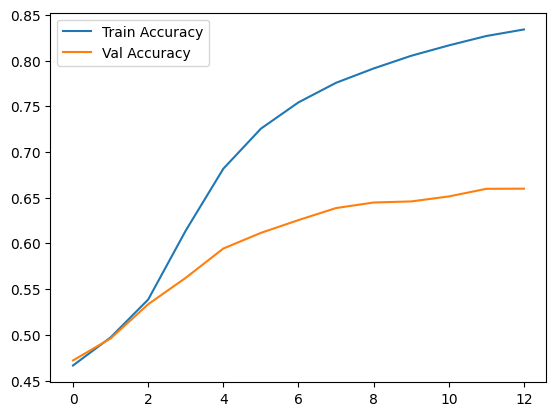

In [78]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

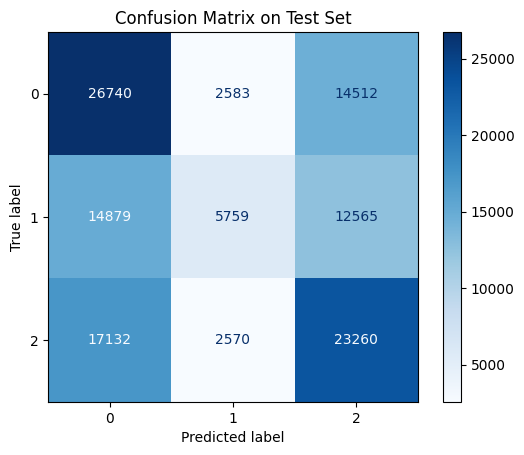

Test Accuracy: 0.4647
Test Precision (macro): 0.4817
Test Recall (macro): 0.4416
Test F1 Score (macro): 0.4270


In [66]:
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, y_pred = outputs.max(1)

        all_y_true.append(y_batch.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)

cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred, average='macro')
recall = recall_score(all_y_true, all_y_pred, average='macro')
f1 = f1_score(all_y_true, all_y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}")